In [11]:
# Standard and scientific Python libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from scipy.ndimage import gaussian_filter1d
import random


In [12]:
# Read BED file and extract valid fragment lengths
fragment_lengths = []

with open("query.bed", "r") as bed_file:
    for line in bed_file:
        fields = line.strip().split()
        if len(fields) >= 3:
            start_pos = int(fields[1])
            end_pos = int(fields[2])
            length = end_pos - start_pos
            if length > 0:
                fragment_lengths.append(length)

# Count occurrences of each length
fragment_length_counts = Counter(fragment_lengths)

# Normalize to get frequency distribution
total_fragments = sum(fragment_length_counts.values())
normalized_fragment_freqs = {
    length: count / total_fragments for length, count in fragment_length_counts.items()
}


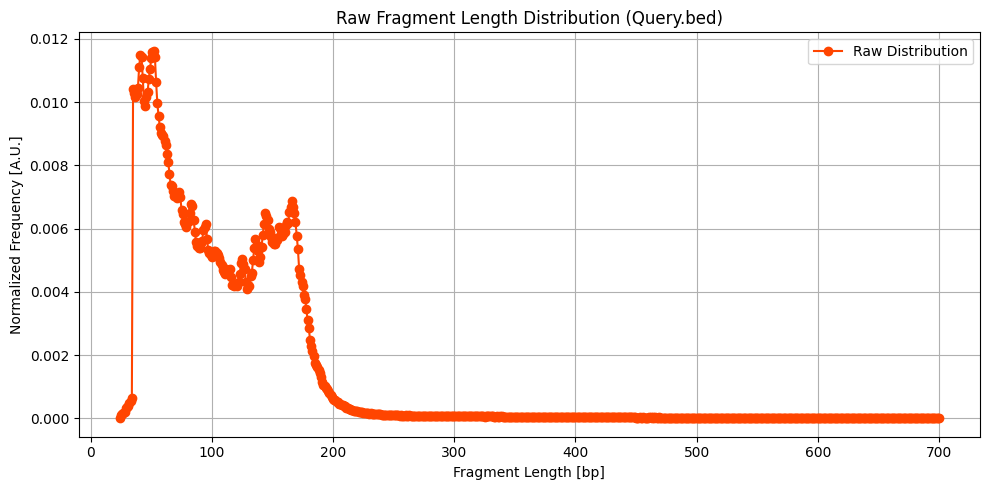

In [13]:
# Sort lengths for plotting
sorted_lengths = sorted(normalized_fragment_freqs.items())
x_lengths = [length for length, _ in sorted_lengths]
y_freqs = [freq for _, freq in sorted_lengths]

# Plot raw distribution
plt.figure(figsize=(10, 5))
plt.plot(x_lengths, y_freqs, marker='o', color='orangered', label="Raw Distribution")
plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Raw Fragment Length Distribution (Query.bed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Load pre-normalized reference histogram
reference_distribution = {}

with open("reference.hist", "r") as ref_file:
    for line in ref_file:
        fields = line.strip().split()
        if len(fields) == 2:
            length = int(fields[0])
            freq = float(fields[1])
            reference_distribution[length] = freq


In [15]:
# Group query BED fragments by their length
fragments_grouped_by_length = defaultdict(list)

with open("query.bed", "r") as bed_file:
    for line in bed_file:
        fields = line.strip().split()
        if len(fields) >= 3:
            start = int(fields[1])
            end = int(fields[2])
            length = end - start
            if length > 0:
                fragments_grouped_by_length[length].append(line)


In [16]:
# Total original fragment count
total_query_count = sum(len(v) for v in fragments_grouped_by_length.values())

# Rescale using reference frequencies
resampled_fragments = []

for length, target_freq in reference_distribution.items():
    if length in fragments_grouped_by_length:
        available = fragments_grouped_by_length[length]
        sample_target = min(len(available), int(target_freq * total_query_count))
        resampled_fragments.extend(random.sample(available, sample_target))


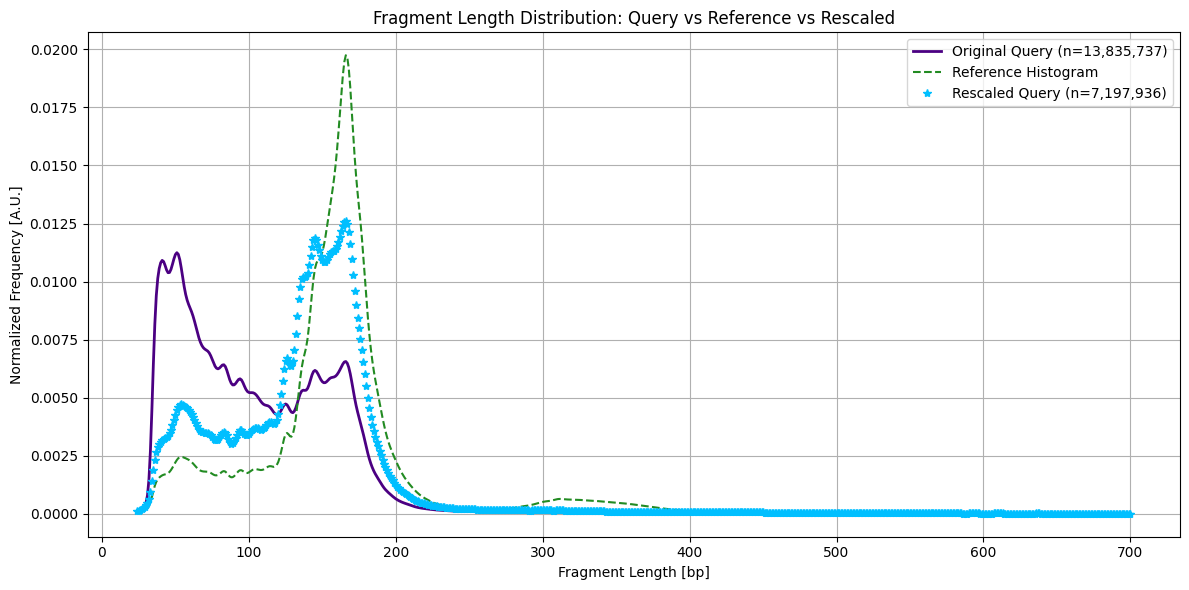

In [17]:
# Get original and rescaled fragment lengths
original_lengths = []
for length, group in fragments_grouped_by_length.items():
    original_lengths.extend([length] * len(group))

resampled_lengths = [
    int(line.split()[2]) - int(line.split()[1]) for line in resampled_fragments
]

# Normalize counts
def get_normalized_counts(lengths):
    counter = Counter(lengths)
    total = sum(counter.values())
    return {length: count / total for length, count in counter.items()}

original_dist = get_normalized_counts(original_lengths)
resampled_dist = get_normalized_counts(resampled_lengths)

# Set of all lengths for consistent alignment
all_unique_lengths = sorted(set(original_dist) | set(resampled_dist) | set(reference_distribution))

def align_distributions(dist):
    return np.array([dist.get(l, 0) for l in all_unique_lengths])

# Prepare aligned and smoothed y-values
y_query = gaussian_filter1d(align_distributions(original_dist), sigma=2)
y_rescaled = gaussian_filter1d(align_distributions(resampled_dist), sigma=2)
y_reference = gaussian_filter1d(align_distributions(reference_distribution), sigma=2)

# Final comparative plot
plt.figure(figsize=(12, 6))
plt.plot(all_unique_lengths, y_query, label=f"Original Query (n={len(original_lengths):,})", color="indigo", linewidth=2)
plt.plot(all_unique_lengths, y_reference, label="Reference Histogram", color="forestgreen", linestyle='--')
plt.plot(all_unique_lengths, y_rescaled, label=f"Rescaled Query (n={len(resampled_lengths):,})", color="deepskyblue", marker='*', linestyle='None')

plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution: Query vs Reference vs Rescaled")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
